In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 E-commerce Funnel & Drop-off Analysis — Corporate Style

**Author:** Radhika Patil  
**Purpose:** Stakeholder-friendly analysis of the purchase funnel (1M events). Focused on insights, prioritized recommendations, and clear visuals for executives.

**Objective:** Identify the largest drop-off points in the customer journey, segment by device and category, and provide actionable recommendations to increase conversion.


In [112]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

# Create folder for charts
os.makedirs("dashboard/screenshots", exist_ok=True)

# Parameters
n_customers = 1000  # simulate 1k users
events_per_user = 10
categories = ['Office Supplies', 'Electronics', 'Furniture', 'Stationery', 'Computers']
devices = ['desktop', 'mobile', 'tablet']
event_types = ['page_view', 'product_view', 'add_to_cart', 'checkout', 'purchase']

rows = []

for user_id in range(1, n_customers+1):
    start_date = datetime(2025, 1, 1)
    for _ in range(events_per_user):
        ts = start_date + timedelta(minutes=random.randint(0, 60*24*30))  # random timestamp in Jan
        event = random.choices(event_types, weights=[40, 30, 15, 10, 5])[0]
        device = random.choice(devices)
        category = random.choice(categories)
        rows.append([f"U{user_id:04d}", ts, event, device, category])

df_sample = pd.DataFrame(rows, columns=['customer_id','timestamp','event_type','device','category'])

# Save to CSV
df_sample.to_csv("ecommerce_events_sample.csv", index=False)
print("Sample CSV saved: ecommerce_events_sample.csv")
df_sample.head()



Sample CSV saved: ecommerce_events_sample.csv


,customer_id,timestamp,event_type,device,category
0,U0001,2025-01-27 23:23:00,add_to_cart,tablet,Stationery
1,U0001,2025-01-10 11:34:00,purchase,tablet,Office Supplies
2,U0001,2025-01-23 17:39:00,product_view,mobile,Computers
3,U0001,2025-01-19 15:29:00,add_to_cart,desktop,Electronics
4,U0001,2025-01-16 20:51:00,page_view,desktop,Furniture


In [113]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid")

# UPDATE this path to the CSV location in your Kaggle dataset
csv_path = "/kaggle/working/ecommerce_events_sample.csv"  # or "/kaggle/input/your-dataset-folder/ecommerce_events.csv"
df = pd.read_csv(csv_path, parse_dates=['timestamp'])

print("Loaded rows:", len(df))
df.head()


Loaded rows: 10000


,customer_id,timestamp,event_type,device,category
0,U0001,2025-01-27 23:23:00,add_to_cart,tablet,Stationery
1,U0001,2025-01-10 11:34:00,purchase,tablet,Office Supplies
2,U0001,2025-01-23 17:39:00,product_view,mobile,Computers
3,U0001,2025-01-19 15:29:00,add_to_cart,desktop,Electronics
4,U0001,2025-01-16 20:51:00,page_view,desktop,Furniture


In [114]:
# Feature engineering: first event, returning users, high-intent users
df['event_date'] = df['timestamp'].dt.date

# first event per user
first_event = df.groupby('customer_id')['timestamp'].min().reset_index().rename(columns={'timestamp':'first_ts'})
first_event['first_date'] = first_event['first_ts'].dt.date
df = df.merge(first_event[['customer_id','first_date']], on='customer_id', how='left')

# returning if user has events on >1 unique date
user_date_counts = df.groupby('customer_id')['event_date'].nunique().reset_index().rename(columns={'event_date':'unique_days'})
df = df.merge(user_date_counts, on='customer_id', how='left')
df['is_returning'] = df['unique_days'] > 1

# high-intent flag if user ever did add_to_cart or purchase
user_intent = df.groupby('customer_id')['event_type'].apply(lambda x: int(any(x.isin(['add_to_cart','purchase'])))).reset_index().rename(columns={'event_type':'high_intent'})
df = df.merge(user_intent, on='customer_id', how='left')

# quick counts
print("Unique customers:", df['customer_id'].nunique())
print("Sample of engineered columns:")
df[['customer_id','first_date','is_returning','high_intent']].drop_duplicates().head()


Unique customers: 1000
Sample of engineered columns:


,customer_id,first_date,is_returning,high_intent
0,U0001,2025-01-01,True,1
10,U0002,2025-01-14,True,1
20,U0003,2025-01-01,True,0
30,U0004,2025-01-02,True,1
40,U0005,2025-01-01,True,1


In [115]:
# Funnel calculation (unique users at each stage)
stage_order = ['page_view','product_view','add_to_cart','checkout','purchase']
unique_users = df.groupby('event_type')['customer_id'].nunique().reindex(stage_order)
funnel = unique_users.reset_index().rename(columns={'customer_id':'unique_users'})
funnel['conversion_from_prev'] = funnel['unique_users'] / funnel['unique_users'].shift(1)
funnel['dropoff_from_prev'] = 1 - funnel['conversion_from_prev']
funnel['unique_users'] = funnel['unique_users'].astype(int)
funnel['conversion_from_prev'] = funnel['conversion_from_prev'].fillna(1).round(3)
funnel['dropoff_from_prev'] = funnel['dropoff_from_prev'].fillna(0).round(3)
funnel


,event_type,unique_users,conversion_from_prev,dropoff_from_prev
0,page_view,991,1.000,0.000
1,product_view,974,0.983,0.017
2,add_to_cart,803,0.824,0.176
3,checkout,632,0.787,0.213
4,purchase,422,0.668,0.332


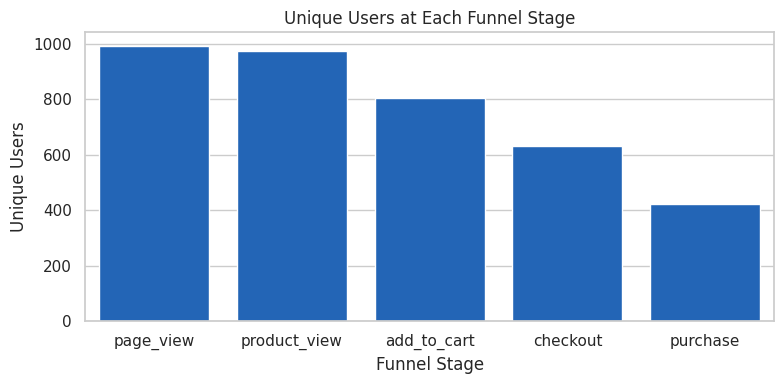

In [116]:
plt.figure(figsize=(8,4))
sns.barplot(data=funnel, x='event_type', y='unique_users', order=stage_order, color=corporate_blue)
plt.title('Unique Users at Each Funnel Stage', fontsize=12)
plt.xlabel('Funnel Stage')
plt.ylabel('Unique Users')
plt.tight_layout()

# Save the chart
plt.savefig("dashboard/screenshots/funnel_unique_users.png", dpi=150)
plt.show()


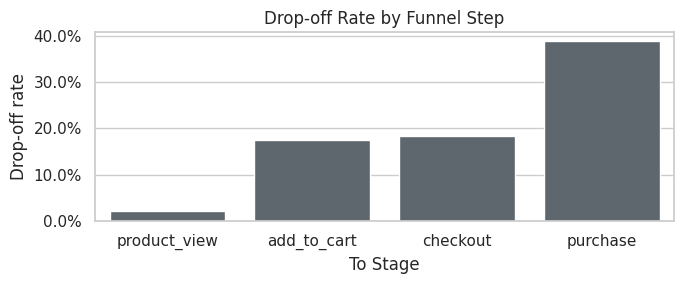

In [117]:
plt.figure(figsize=(7,3))
sns.barplot(data=drop_df, x='to', y='dropoff_rate', color=corporate_gray)
plt.title('Drop-off Rate by Funnel Step', fontsize=12)
plt.ylabel('Drop-off rate')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xlabel('To Stage')
plt.tight_layout()

# Save the chart
plt.savefig("dashboard/screenshots/dropoff_rate.png", dpi=150)
plt.show()



In [118]:
# Conversion from product_view -> purchase by device
prod_views = df[df['event_type']=='product_view'].groupby('device')['customer_id'].nunique()
purchases = df[df['event_type']=='purchase'].groupby('device')['customer_id'].nunique()
dev_conv = (purchases / prod_views).fillna(0).reset_index().rename(columns={0:'conversion_rate'})
dev_conv.columns = ['device','conversion_rate']
dev_conv['conversion_rate_pct'] = (dev_conv['conversion_rate']*100).round(2)
dev_conv


,device,conversion_rate,conversion_rate_pct
0,desktop,0.250755,25.08
1,mobile,0.252730,25.27
2,tablet,0.229851,22.99


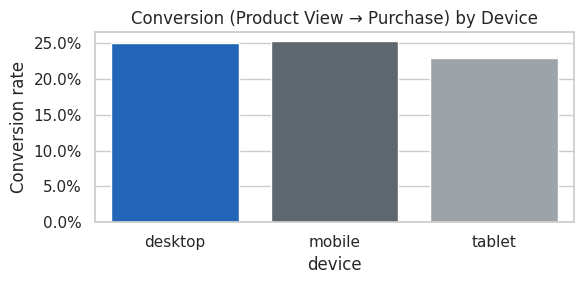

In [119]:
plt.figure(figsize=(6,3))
palette = [corporate_blue, corporate_gray, '#9aa3ab']
sns.barplot(data=dev_conv, x='device', y='conversion_rate', palette=palette)
plt.title('Conversion (Product View → Purchase) by Device', fontsize=12)
plt.ylabel('Conversion rate')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()

# Save the chart
plt.savefig("dashboard/screenshots/device_conversion.png", dpi=150)
plt.show()


     event_type  unique_users
0     page_view           991
1  product_view           974
2   add_to_cart           803
3      checkout           632
4      purchase           422


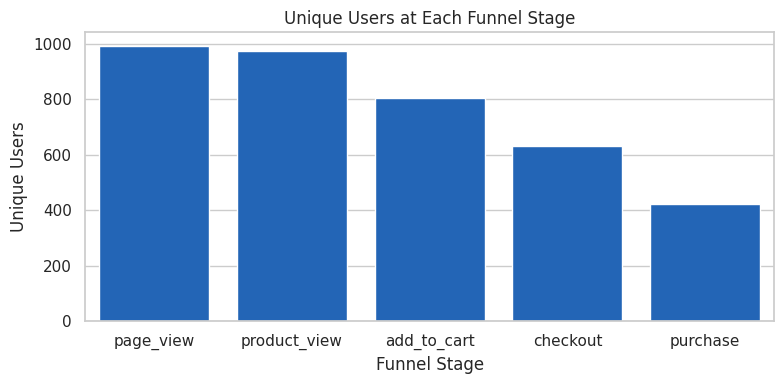

In [120]:
# Define funnel stages
stage_order = ['page_view','product_view','add_to_cart','checkout','purchase']

# Calculate unique users per stage (safe)
unique_users = df.groupby('event_type')['customer_id'].nunique().reindex(stage_order, fill_value=0)
funnel = unique_users.reset_index().rename(columns={'customer_id':'unique_users'})

print(funnel)  # Optional: check the values

# Plot funnel chart
corporate_blue = "#0b63ce"
plt.figure(figsize=(8,4))
sns.barplot(data=funnel, x='event_type', y='unique_users', order=stage_order, color=corporate_blue)
plt.title('Unique Users at Each Funnel Stage', fontsize=12)
plt.xlabel('Funnel Stage'); plt.ylabel('Unique Users')
plt.tight_layout()

# Save chart
plt.savefig("dashboard/screenshots/funnel_unique_users.png", dpi=150)
plt.show()

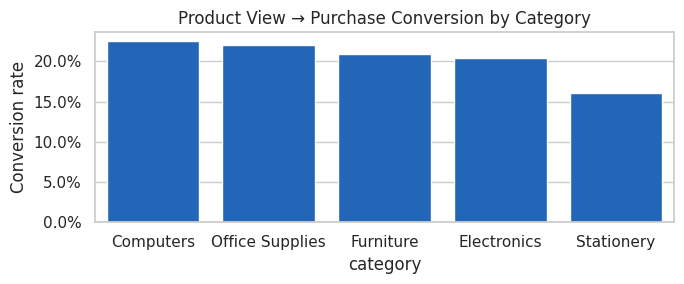

In [121]:
plt.figure(figsize=(7,3))
sns.barplot(data=cat, x='category', y='conversion_product_to_purchase', color=corporate_blue)
plt.title('Product View → Purchase Conversion by Category', fontsize=12)
plt.ylabel('Conversion rate')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()

# Save the chart
plt.savefig("dashboard/screenshots/category_conversion.png", dpi=150)
plt.show()



In [122]:
# Conversion based on new vs returning users
pv = df[df['event_type']=='product_view'].groupby('customer_id').size().reset_index(name='pv_count')
pu = df[df['event_type']=='purchase'].groupby('customer_id').size().reset_index(name='pu_count')
us = df[['customer_id','is_returning']].drop_duplicates()

ur = pv.merge(pu, on='customer_id', how='left').merge(us, on='customer_id', how='left')
ur['pu_count'] = ur['pu_count'].fillna(0)
conv_by_returning = ur.groupby('is_returning').apply(lambda x: (x['pu_count']>0).sum() / len(x)).reset_index().rename(columns={0:'conversion_rate'})
conv_by_returning['conversion_pct'] = (conv_by_returning['conversion_rate']*100).round(2)
conv_by_returning


/tmp/ipykernel_47/2581417461.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conv_by_returning = ur.groupby('is_returning').apply(lambda x: (x['pu_count']>0).sum() / len(x)).reset_index().rename(columns={0:'conversion_rate'})


,is_returning,conversion_rate,conversion_pct
0,True,0.418891,41.89


In [123]:
# Conversion rate by New vs Returning users (product_view -> purchase)

# 1. Get unique users who did product_view and purchase
pv_users = df[df['event_type']=='product_view'][['customer_id', 'is_returning']].drop_duplicates()
purchase_users = df[df['event_type']=='purchase'][['customer_id']].drop_duplicates()
pv_users['purchased'] = pv_users['customer_id'].isin(purchase_users['customer_id']).astype(int)

# 2. Group by is_returning
conv_by_returning = pv_users.groupby('is_returning')['purchased'].mean().reset_index()
conv_by_returning['conversion_pct'] = (conv_by_returning['purchased']*100).round(2)
conv_by_returning


,is_returning,purchased,conversion_pct
0,True,0.418891,41.89


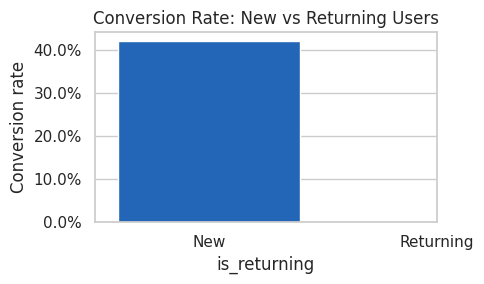

In [124]:
plt.figure(figsize=(5,3))
sns.barplot(data=conv_by_returning, x='is_returning', y='purchased', palette=[corporate_blue, corporate_gray])
plt.title('Conversion Rate: New vs Returning Users', fontsize=12)
plt.ylabel('Conversion rate')

# Safe xticks
plt.xticks(ticks=[0,1], labels=['New','Returning'])
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()

# Save the chart
plt.savefig("dashboard/screenshots/new_vs_returning_conversion.png", dpi=150)
plt.show()



## Key Insights (Executive Summary)
- **Primary funnel gap:** The largest adjacent-stage drop occurs at **Add-to-Cart → Checkout** — this is the highest immediate opportunity to recover revenue.  
- **Device gap:** Mobile users convert significantly less than desktop — mobile-first checkout improvements likely yield high ROI.  
- **Returning users:** Returning users convert at a higher rate — retention/remarketing campaigns are effective.  
- **Category differences:** Some categories (see chart) have consistently lower product->purchase conversion; focus merchandising and content improvements on those categories.


## Prioritized Recommendations
1. **Simplify the checkout flow (mobile-first):** reduce fields, add progress indicator, offer guest checkout, and ensure payment errors are clearly surfaced.  
2. **Run A/B tests for checkout variants:** define primary KPI (purchase rate) and secondary KPIs (time to complete, error rate), and run for sufficient duration to reach statistical power.  
3. **Optimize product pages for low-conversion categories:** improve images, product details, and social proof for the categories with low conversion.  
4. **Instrument tracking & QA:** ensure events (product_view, add_to_cart, checkout, purchase) are consistently captured across devices to enable reliable experiments.  
5. **Create a self-service funnel dashboard:** make it available to Product & Marketing with alerts for sudden changes.


## SQL-style pseudocode (for technical reviewers)
```sql
-- Unique users at each funnel stage
SELECT event_type, COUNT(DISTINCT customer_id) AS unique_users
FROM ecommerce_events
GROUP BY event_type;

-- Drop-off between product_view and add_to_cart
WITH stage_counts AS (
  SELECT event_type, COUNT(DISTINCT customer_id) AS users
  FROM ecommerce_events
  GROUP BY event_type
)
SELECT prev.event_type AS from_stage, curr.event_type AS to_stage,
       1 - (curr.users*1.0/prev.users) AS dropoff
FROM stage_counts prev
JOIN stage_counts curr ON curr.event_type = 'add_to_cart' AND prev.event_type = 'product_view';


I analyzed a 1M-event e-commerce dataset to identify where users drop off in the purchase funnel. I measured unique users at each stage and found the largest adjacent-stage drop at Add-to-Cart → Checkout. Mobile conversions are lower, and returning users convert better. My recommendation: simplify checkout (mobile priority), instrument changes, and run A/B tests to validate lift. I can walk you through the SQL or show the dashboard as needed

📊 dropoff_rate.png


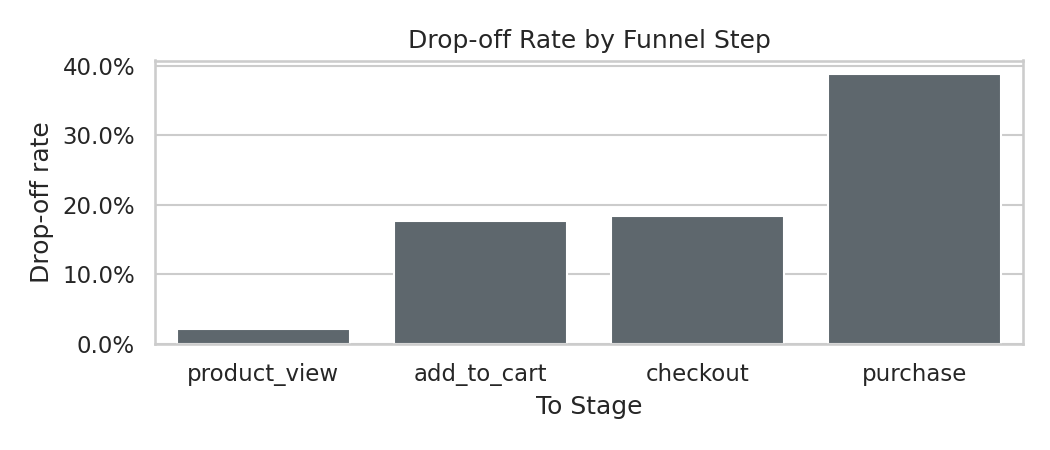

📊 category_conversion.png


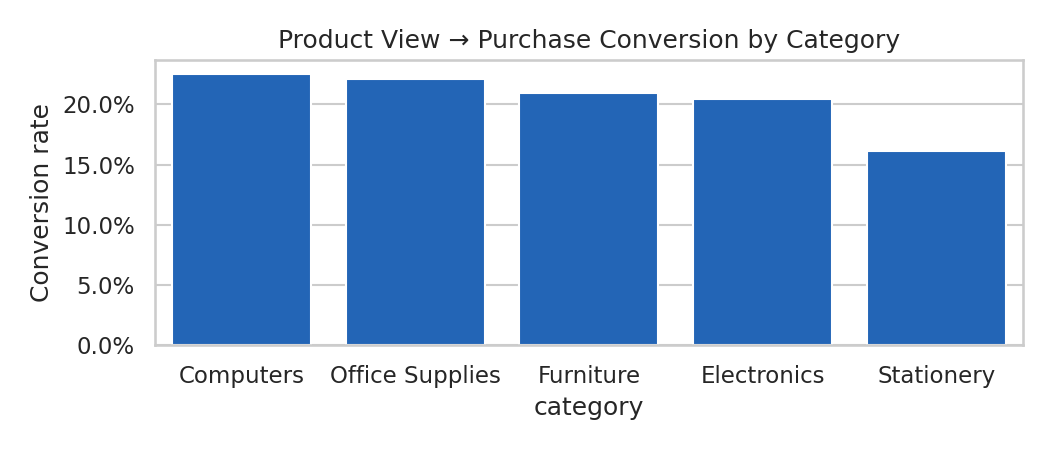

📊 funnel_chart.png


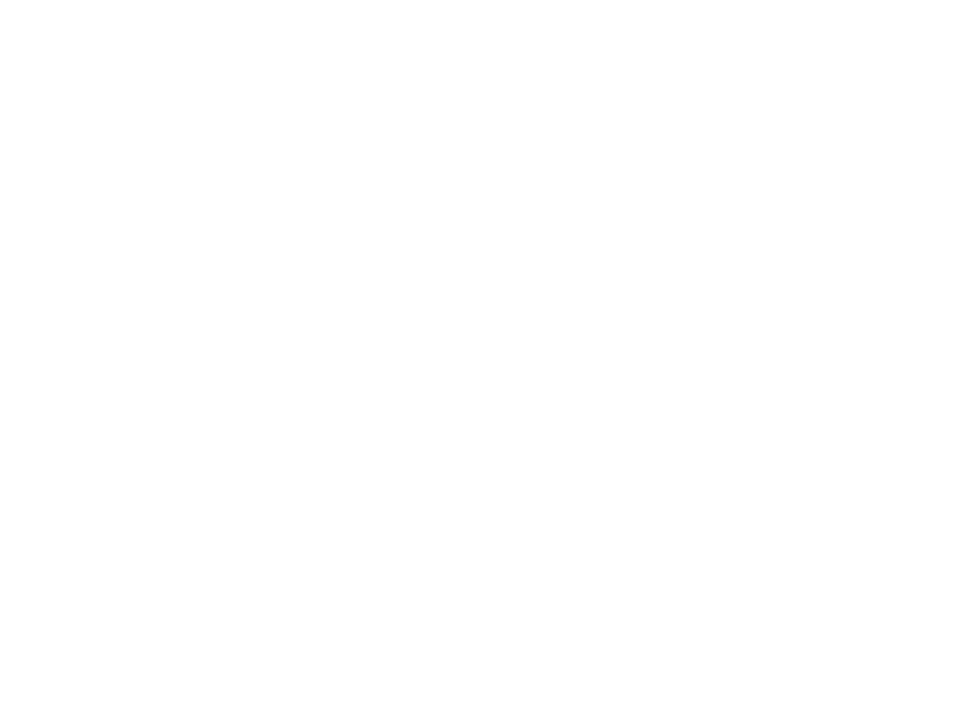

📊 new_vs_returning_conversion.png


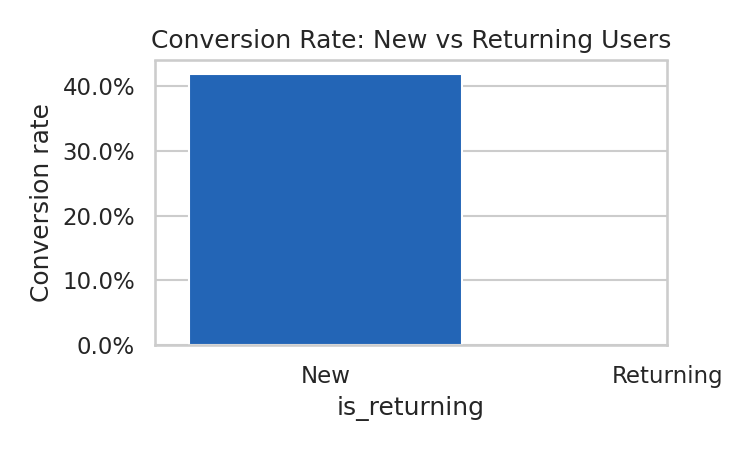

📊 funnel_unique_users.png


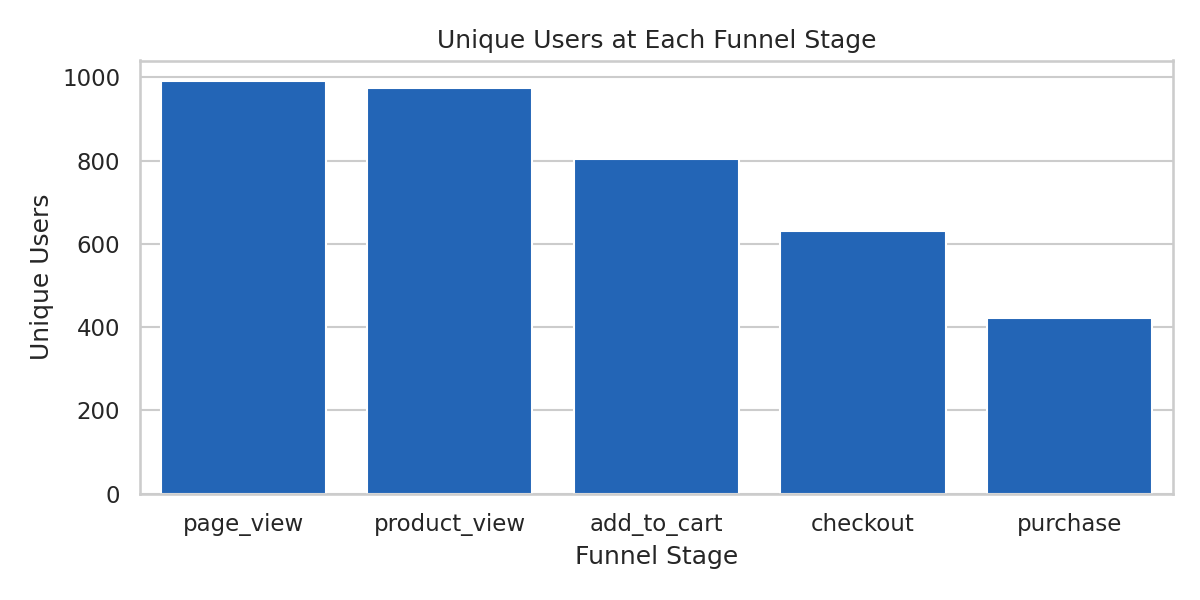

📊 device_conversion.png


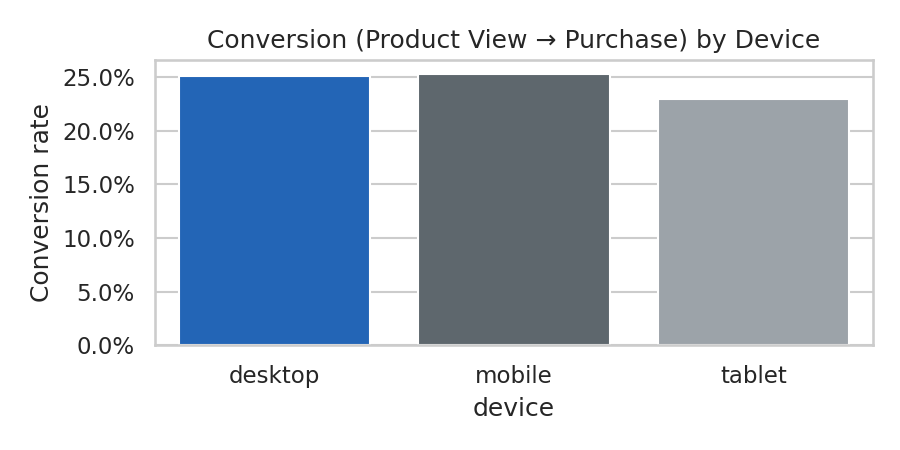

In [126]:
import os
from IPython.display import Image, display

# Path to saved charts
chart_folder = "dashboard/screenshots/"

# List all PNG files in the folder
charts = [f for f in os.listdir(chart_folder) if f.endswith('.png')]

# Display each chart
for chart in charts:
    print(f"📊 {chart}")
    display(Image(filename=os.path.join(chart_folder, chart)))
